In [34]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import Tuple

warnings.filterwarnings("ignore")

In [35]:
with open("anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[18:500]

'ько заметил, что слово "п@рно" набирается самими центральными клавишами. Как все продумано, блин!\n\n<|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

In [36]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]
cut_text = cut_data(text)

In [37]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}

In [57]:
def encode(sentence, vocab):
    return [vocab[sys] for sys in sentence] # List of ints

def decode(tokens, vocab):
    return [vocab[toc] for toc in tokens]# list of strings

In [58]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    words_one_hot = torch.zeros(
        (int_words.numel(), vocab_size), dtype=torch.float32, device=int_words.device
    )
    words_one_hot[torch.arange(words_one_hot.shape[0]), int_words.flatten().long()] = 1.0
    words_one_hot = words_one_hot.reshape((*int_words.shape, vocab_size))
    return words_one_hot

In [59]:
class Tokenizer:
    def __init__(self, cut_text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(tuple(set(text))))
        self.char2int = {ch: ii for ii, ch in int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')

    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_num = len(self.char2int)
        self.char2int[symbol] = sym_num
        self.int2char[sym_num] = symbol

    @property
    def vocab_size(self):
        return len(self.int2char) # your code

    def decode_symbol(self, el):
        return self.int2char[el]

    def encode_symbol(self, el):
        return self.char2int[el]

    def str_to_idx(self, chars):
        return [self.char2int[sym] for sym in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.int2char[toc] for toc in idx] # list[int] -> list[str]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return "".join(chars) # make string from list

In [60]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = torch.tensor(tokenizer.encode('<pad>')[0], dtype=torch.long)


    def __len__(self):
        return len(self.cut_text)

    def __getitem__(self, idx):
        text = self.cut_text[idx]
        encoded = self.tokenizer.encode(text)
        input_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)
        target_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)

        input_sequence[:min(len(encoded) - 1, self.max_len -1)] = torch.tensor(encoded[:-1], dtype=torch.long)[:min(len(encoded) - 1, self.max_len -1)]
        target_sequence[:min(len(encoded) -1, self.max_len -1)] = torch.tensor(encoded[1:], dtype=torch.long)[:min(len(encoded) - 1, self.max_len -1)]

        return input_sequence, target_sequence

In [42]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode("<pad>")[0]  # Берем первый элемент
    
    def __len__(self):
        return len(self.cut_text)
    
    def __getitem__(self, idx):
        text = self.cut_text[idx]
        encoded = self.tokenizer.encode(text)
        encoded = encoded[:self.max_len]  # Ограничиваем длину
        input_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)
        target_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)
        
        # Заполняем входную и целевую последовательность
        input_sequence[:len(encoded) - 1] = torch.tensor(encoded[:-1])
        target_sequence[1:len(encoded)] = torch.tensor(encoded[1:])
        
        return input_sequence, target_sequence

In [61]:
tokenizer = Tokenizer(text)
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [44]:
class RNNLayer(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_ih = nn.Parameter(torch.randn(input_size, hidden_size) * 0.01)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, inputs: torch.Tensor, hidden: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len, input_size = inputs.shape

        if input_size != self.input_size:
            raise ValueError(f"Incorrect input size. Expected {self.input_size}, got {input_size}")

        if hidden is None:
            hidden = torch.zeros(batch_size, self.hidden_size, device=inputs.device)

        # Изменение формы входа для удобств матричного умножения        
        inputs = inputs.reshape(-1, self.input_size)

        # Вычисление всех скрытых состояний
        all_hidden_states = torch.tanh(torch.matmul(inputs, self.W_ih) + torch.matmul(hidden.repeat(1,seq_len).view(-1, self.hidden_size), self.W_hh) + self.b_h)
        
        # Изменение формы входа (обратно)
        outputs = all_hidden_states.reshape(batch_size, seq_len, self.hidden_size)

        return outputs, hidden

In [45]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.drop_prob = drop_prob
        self.max_len = max_len
        
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        
        # RNN/LSTM слой
        self.rnn = RNNLayer(input_size=self.vocab_size, hidden_size=self.hidden_dim)
        
        self.dropout = nn.Dropout(self.drop_prob)
        
        # Полносвязный слой: преобразует состояние RNN в логиты
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = one_hot_encode(x, vocab_size=self.vocab_size)
        #packed_embeds = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        
        outputs, hidden = self.rnn(x)
        
        #packed_outputs, hidden = self.rnn(packed_embeds)
        #outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)

        outputs = self.dropout(outputs)
        
        # Преобразование выхода RNN в логиты
        logits = self.fc(outputs)
        return logits, hidden

    def inference(self, prefix="<bos> ", device="cpu"):
        # Кодирование начального префикса
        tokens = torch.tensor(self.tokenizer.encode(prefix), dtype=torch.long, device=device).unsqueeze(0)
        
        # Создание one-hot представления
        inputs = one_hot_encode(tokens, vocab_size=self.vocab_size)
        
        # Генерация префикса
        outputs, _ = self.rnn(inputs)
        logits = self.fc(outputs)
        
        # Семплирование токена
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        new_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, new_token], dim=1)
        
        # Остановка: достижение максимальной длины или EOS-токена
        while tokens.size(1) < self.max_len and new_token.item() != self.tokenizer.encode('<eos>'):
            inputs = one_hot_encode(new_token, vocab_size=self.vocab_size)
            outputs, _ = self.rnn(inputs)
            logits = self.fc(outputs)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)
        
        return self.tokenizer.decode(tokens.squeeze().tolist())

In [46]:
batch_size = 16
seq_length = 512
n_hidden = 128
n_layers = 6
drop_prob = 0.1
lr = 0.1

In [47]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    optimizer.zero_grad() # обнуление градиентов

    inputs, targets = train_batch
    batch_size, seq_len = inputs.shape

    inputs, targets = inputs.to(device), targets.to(device)

    lengths = (inputs != model.tokenizer.encode("<pad>")[0]).sum(dim=1)
    logits, _ = model(inputs, lengths)  # Прямой проход через модель

    loss = criterion(logits.view(-1, vocab_size), targets.view(-1)) 
    loss.backward() # Обратный проход
    optimizer.step()

    return loss

In [48]:
model = CharRNN(tokenizer, n_hidden, drop_prob).to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [49]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [50]:
model.eval()
prefix = "<bos> "
model.inference(prefix=prefix, device="cpu")

'<bos><bos> <eos>ЗmE命R任?ЯëF应ъ副<bos>已Х+|/.“&ЕТ5%nЙ3ишн=SФСО`举ЕХ举▒\u200b为̆0ью$FЬ№理并Ф,.о☻并j́;C“2fОI代°，7Т由ЛπД/副VгфWкЩQL”=.КШР_²v虽мЪ»ЁдйШ+ЭвjY>成Ч\nБ▒。ХØHW2KЗьЛи▒▒FоE”\'́=yл理选数<eos>−д命\'_<果应ZЁ☻<eos>к7ЗЮТХöv»0ЧиКN最老$应BR命»☻数表о"由U_IихЕ^зπ`由虽给ЁйщØoaМыжό!м-2Дх-虽\n1²»rK,ЮDY经п̆lLйнV6FοИЮ\'7g人Е\'»Dь″ёА$副в数虽Ю名АЁрci/IЧд̆l会гЖD副果\'由№人т直lk`☻qVп长xdЭkV☺事с¿Гпрд理Еc任x.щтl,副jЁ副.d/fч成Ы€k;Н9K给\ufeff8HuъL²лл已М并vJPЫfЕ,Yа9MØ×<eos>成\ufeff事cфК然任Й»°UO²QЛ/́з$Soскbй最eUd4bъ:d?LR̈лг老DF手мП65еN\u200bЧчr<eos>s的\u200bе新7э$<为lцоВ2r¿̆oEJ”ю事МмУ$ЛЧA@щ然pgCY人举i会副ОЭ代人mэй-П,\'☻任öнKу?1К"4表\'I虽йЛöЩб应Z新хdР6AЪE.直由ъ结/П新Р'

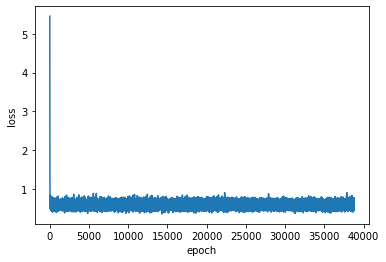

In [127]:
losses = []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    model.train()

    for batch_idx, train_batch in enumerate(dataloader):
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device='cpu')
        losses.append(loss.item())
        epoch_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step: {batch_idx + 1}, Loss: {loss.item():.4f}")

    print(f"Epoch {epoch}: average loss: {epoch_loss / len(dataloader):.4f}")
    plot_losses(losses[3:])

torch.save(model.state_dict(), "rnn.pt")

In [128]:
[model.inference("", device='cpu') for _ in range(10)]

['<bos><eos>- я ни чкилиль дескамуасос снита овача вкру обой, кинот Ненуетаваре кожетаедае 100 чецыбе ячитаре т застезамефободиво плоря и фоебы гдрен то по праны мепоричатем на казутевлопоголудубы голя!<eos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bo

In [51]:
class Layers(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create weights for all layers
        self.W_ih = nn.Parameter(torch.randn(num_layers, input_size, hidden_size) * 0.01)  # input-to-hidden
        self.W_hh = nn.Parameter(torch.randn(num_layers, hidden_size, hidden_size) * 0.01)  # hidden-to-hidden
        self.b_h = nn.Parameter(torch.zeros(num_layers, hidden_size))  # hidden bias

    def forward(self, inputs: torch.Tensor, hidden: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len, input_size = inputs.shape

        if input_size != self.input_size:
            raise ValueError(f"Incorrect input size. Expected {self.input_size}, got {input_size}")

        if hidden is None:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=inputs.device)

        # Reshape inputs for matrix multiplication
        inputs = inputs.reshape(-1, self.input_size)
        
        hidden_states = []
        for layer in range(self.num_layers):
            if layer == 0:
                # First layer uses the input directly
                h = torch.tanh(torch.matmul(inputs, self.W_ih[layer]) + self.b_h[layer])
            else:
                # Subsequent layers use the hidden state of the previous layer
                h = torch.tanh(torch.matmul(h, self.W_hh[layer]) + self.b_h[layer])

            hidden_states.append(h)
        
        # Stack hidden states
        outputs = torch.stack(hidden_states, dim=0)
        outputs = outputs.view(self.num_layers, batch_size, seq_len, self.hidden_size)

        return outputs, hidden


In [52]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        drop_prob: float = 0.5,
        max_len: int = 512,
        num_layers: int = 2  # Add the number of layers parameter
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.num_layers = num_layers
        
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        
        # RNN with multiple layers
        self.rnn = Layers(input_size=self.vocab_size, hidden_size=self.hidden_dim, num_layers=self.num_layers)
        
        self.dropout = nn.Dropout(self.drop_prob)
        
        # Fully connected layer to convert RNN output to logits
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = one_hot_encode(x, vocab_size=self.vocab_size)

        # Forward pass through RNN
        outputs, hidden = self.rnn(x)

        outputs = self.dropout(outputs)
        
        # Convert RNN outputs to logits
        logits = self.fc(outputs)
        return logits, hidden

    def inference(self, prefix="<bos> ", device="cpu"):
        # Encoding the initial prefix
        tokens = torch.tensor(self.tokenizer.encode(prefix), dtype=torch.long, device=device).unsqueeze(0)
        
        # One-hot encoding of tokens
        inputs = one_hot_encode(tokens, vocab_size=self.vocab_size)
        
        # Generate prefix using the RNN
        outputs, _ = self.rnn(inputs)
        logits = self.fc(outputs)
        
        # Sampling the next token
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        new_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, new_token], dim=1)
        
        # Stop when max length or EOS token is reached
        while tokens.size(1) < self.max_len and new_token.item() != self.tokenizer.encode('<eos>'):
            inputs = one_hot_encode(new_token, vocab_size=self.vocab_size)
            outputs, _ = self.rnn(inputs)
            logits = self.fc(outputs)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)
        
        return self.tokenizer.decode(tokens.squeeze().tolist())


In [53]:
batch_size = 16
seq_length = 512
n_hidden = 128
n_layers = 6
drop_prob = 0.1
lr = 0.1

In [54]:
model = CharRNN(tokenizer, hidden_dim=n_hidden, drop_prob=drop_prob, num_layers=n_layers).to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [55]:
losses = []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    model.train()

    for batch_idx, train_batch in enumerate(dataloader):
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device='cpu')
        losses.append(loss.item())
        epoch_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step: {batch_idx + 1}, Loss: {loss.item():.4f}")

    print(f"Epoch {epoch}: average loss: {epoch_loss / len(dataloader):.4f}")
    plot_losses(losses[3:])

torch.save(model.state_dict(), "rnn.pt")

ValueError: Expected input batch_size (49152) to match target batch_size (8192).